## Illustrating Multiplicative Noise Effects

**Note:** This notebook is intended for illustrative purposes only. It demonstrates the effect of **multiplicative noise** in the degradation model and is not part of the core training or evaluation pipeline.

In [9]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.particle_filter.mixture import MixtureDegModel

from src.models.particle_filter.core import ParticleFilterModel,ParticleFilterMLP

from experiment_config import (
    DegModel,DATA_NAME,FILTERED_SUFFIX,SEED,PFNET_NAME,LEAKY_SLOPE,HIDDEN_DIMS,PREDICTION_START_IDX
)

## Parameters

In [10]:
perform_name = 'SmHPC'

In [11]:
degmodel_name = DegModel.name()
experiment_dir = Path('experiments')/DATA_NAME
degmodel_dir = experiment_dir/'degradation'/degmodel_name
states_dir = experiment_dir/f'degradation{FILTERED_SUFFIX}'/DegModel.name()/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data

In [12]:
hi_df = pd.read_csv(experiment_dir/f'hidata_dev{FILTERED_SUFFIX}.csv')
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

### Extract degradation onset

In [13]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [14]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [ ]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 
s = np.linspace(0.0, 1.0, 300)

pf_models: dict[str,ParticleFilterModel]= {}
for name, units_perform in performs.items():
    models = []
    for unit, perform in units_perform.items():
        best_model = DegModel()
        best_model.load_state_dict(
			torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
		)
        best_model.eval()
        models.append(best_model)
    net = ParticleFilterMLP(state_dim=DegModel.state_dim(),hidden_dims=[3, 16])
    pf_models[name]=ParticleFilterModel(base_models=models,
                        net=net,
                        n_particles=90)

## Mixture pdf 

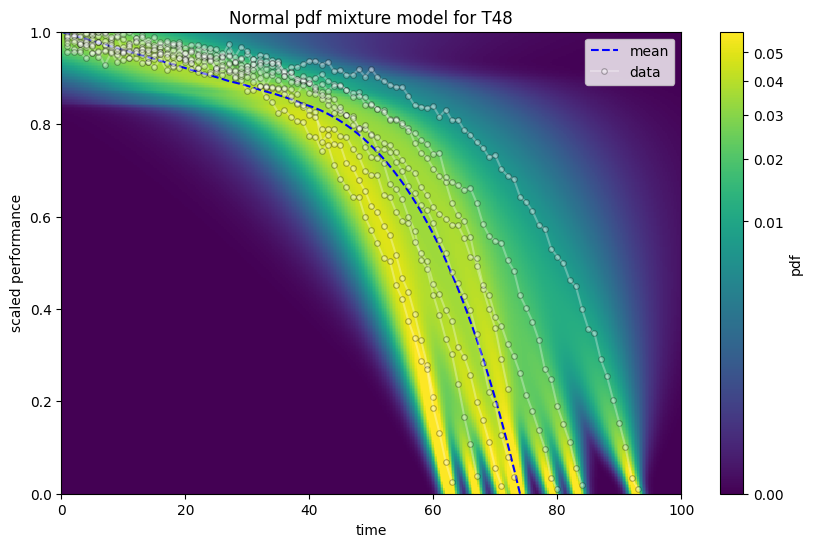

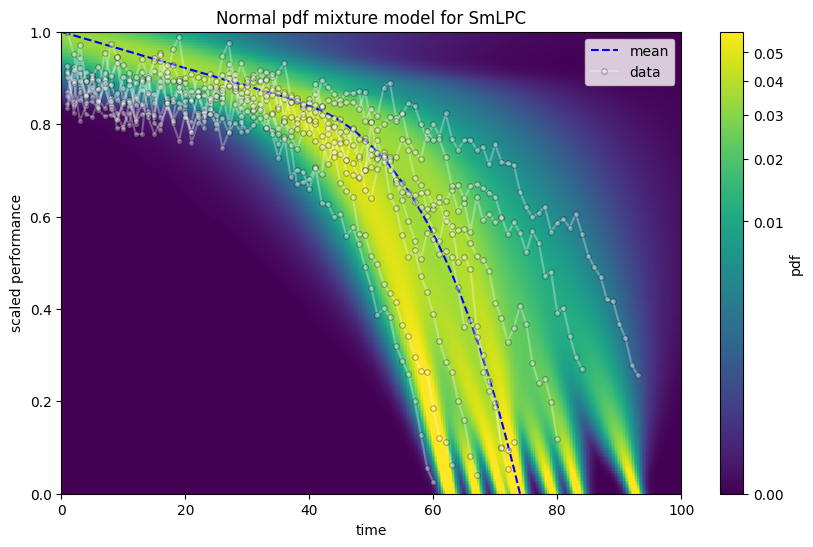

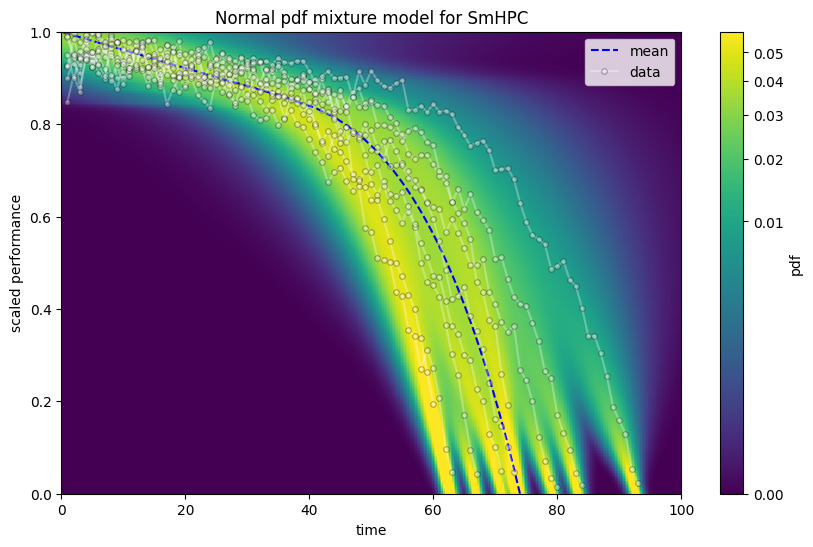

In [16]:
mixes: dict[str,MixtureDegModel]= {}
for name, pf_model in pf_models.items():
    ## Plot mix model
    mix_model = pf_model.mixture
    ax=mix_model.plot_distribution(t, s, 
                    func="pdf",
					title=f"{DegModel.name().capitalize()} pdf mixture model for {name}",
					plot_mean=True,
		)
    
    # Plot data
    first = True
    for unit,s_data in performs[name].items():
        t_data = time[unit]
        ax.plot(t_data,s_data,'o-',
				color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
				label='data' if first else None)
        first = False
    
    # adjust and plot
    ax.set_xlim([0, t.max()])
    ax.legend()
    plt.show()